Decision tree ID3

In [71]:
import pandas as pd
import numpy as np
import math

In [72]:
data = pd.read_csv('ANUBHAV JHA - diabetes_dataset.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [73]:
data.shape

(768, 9)

Entropy calculation

In [74]:
# calculate entropy for decision tree

def calculate_entropy(data, target_column):
    total_rows = len(data)
    target_values = data[target_column].unique()

    entropy = 0
    for value in target_values:
        # Calculate the proportion of instances with the current value
        value_count = len(data[data[target_column] == value])
        proportion = value_count / total_rows
        entropy -= proportion * math.log2(proportion)

    return entropy


In [75]:
entropy = calculate_entropy(data,'Outcome')

In [76]:
entropy

0.9331343166407831

In [77]:
def calculate_information_gain(data, feature, target_column, target_entropy):

  unique_values = data[feature].unique()
  weighted_entropy = 0

  for value in unique_values:
      subset = data[data[feature] == value]
      proportion = len(subset) / len(data)
      weighted_entropy += proportion * calculate_entropy(subset, target_column)

  information_gain = target_entropy - weighted_entropy

  return information_gain

In [78]:
ig = []
for i in data.columns[:-1]: # dont do for outcome
    ig.append(calculate_information_gain(data, i, 'Outcome',entropy))

In [79]:
cols = data.columns[:-1].tolist()
for i in range(len(cols)):
    print(f"{cols[i]}\t{calculate_entropy(data,cols[i]):.3f}\t{ig[i]:.3f}")

Pregnancies	3.482	0.062
Glucose	6.751	0.304
BloodPressure	4.792	0.059
SkinThickness	4.586	0.082
Insulin	4.682	0.277
BMI	7.594	0.344
DiabetesPedigreeFunction	8.829	0.651
Age	5.029	0.141


In [80]:
def id3(data, target_column, features, target_entropy, max_depth=None, depth=0):

    # 1. If all rows have the same target value, return the target value
    if len(data[target_column].unique()) == 1:
        return data[target_column].iloc[0]

    # 2. If there are no more features to split on or max depth is reached
    if len(features) == 0 or (max_depth is not None and depth >= max_depth):
        # Assign the majority class in the current subset
        return data[target_column].mode()[0]

    # 3. Otherwise, select the feature with the highest information gain
    best_feature = None
    best_info_gain = -np.inf
    for feature in features:
        info_gain = calculate_information_gain(data, feature, target_column, target_entropy)
        if info_gain > best_info_gain:
            best_info_gain = info_gain
            best_feature = feature

    # If there's no feature with positive information gain, assign majority class
    if best_info_gain <= 0:
        return data[target_column].mode()[0]

    # Create the node (which is a dictionary representing the tree)
    tree = {best_feature: {}}

    # Get the unique values of the best feature
    unique_values = data[best_feature].unique()

    # Remove the chosen feature from the list of features
    remaining_features = [f for f in features if f != best_feature]

    # Recursively build the tree for each value of the best feature
    for value in unique_values:
        subset = data[data[best_feature] == value]

        # Calculate the target entropy for the subset
        subset_target_entropy = calculate_entropy(subset, target_column)

        # Recursively build the tree for the subset
        tree[best_feature][value] = id3(subset, target_column, remaining_features, subset_target_entropy, max_depth, depth + 1)

    return tree



In [81]:
from sklearn.model_selection import train_test_split

# Assuming your data is a pandas DataFrame
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [82]:
tree = id3(train_data,'Outcome',data.columns[:-1],entropy,max_depth=9)

In [83]:
def predict(tree, sample):
    # Traverse the tree based on the feature values of the sample
    if isinstance(tree, dict):
        # Get the feature to split on
        feature = list(tree.keys())[0]
        feature_value = sample[feature]

        # Go to the corresponding branch in the tree
        if feature_value in tree[feature]:
            return predict(tree[feature][feature_value], sample)
    else:
        # Return the predicted class
        return tree


In [84]:
def accuracy(test_data, target_column):
  correct_predictions = 0
  total_predictions = len(test_data)

  for index, row in test_data.iterrows():
      prediction = predict(tree, row)
      if prediction == row[target_column]:
          correct_predictions += 1

  accuracy = correct_predictions / total_predictions
  return accuracy


In [85]:
own_acc_train = accuracy(train_data,"Outcome")
print(own_acc_train)

1.0


In [86]:
own_acc_test = accuracy(test_data,"Outcome")
print(own_acc_test)

0.24025974025974026


In [87]:
#make decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier()
model.fit(train_data.drop('Outcome',axis=1),train_data['Outcome'])

DecisionTreeClassifier()

In [88]:
#test model on training set

y_pred = model.predict(test_data.drop('Outcome',axis=1))
print(f"{accuracy_score(test_data['Outcome'],y_pred)*100:.2f}%")

76.62%


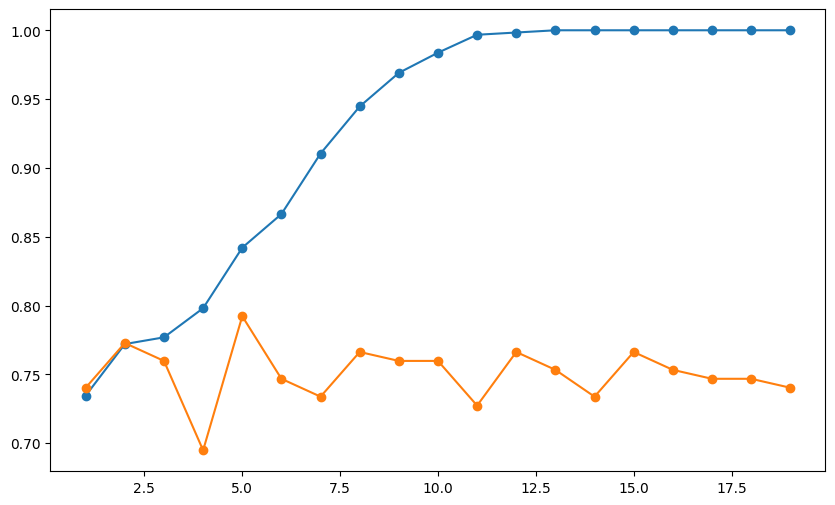

In [89]:
# display curve for max depth vs accuracy on train and test data

import matplotlib.pyplot as plt

max_depths = range(1, 20)
train_accuracies = []
test_accuracies = []

for max_depth in max_depths:
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(train_data.drop('Outcome',axis=1),train_data['Outcome'])

    y_pred_train = model.predict(train_data.drop('Outcome',axis=1))
    y_pred_test = model.predict(test_data.drop('Outcome',axis=1))

    train_accuracy = accuracy_score(train_data['Outcome'], y_pred_train)
    test_accuracy = accuracy_score(test_data['Outcome'], y_pred_test)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# plot
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(max_depths, test_accuracies, marker='o', label='Test Accuracy')

In [90]:
# visualize a smaller tree

X = data.drop('Outcome',axis=1)
y = data['Outcome']
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
best_model = DecisionTreeClassifier(max_depth=3)
best_model.fit(train_data.drop('Outcome',axis=1),train_data['Outcome'])

DecisionTreeClassifier(max_depth=3)

In [91]:
pre_buit_accuracy_test = best_model.score(test_data.drop('Outcome',axis=1),test_data['Outcome'])


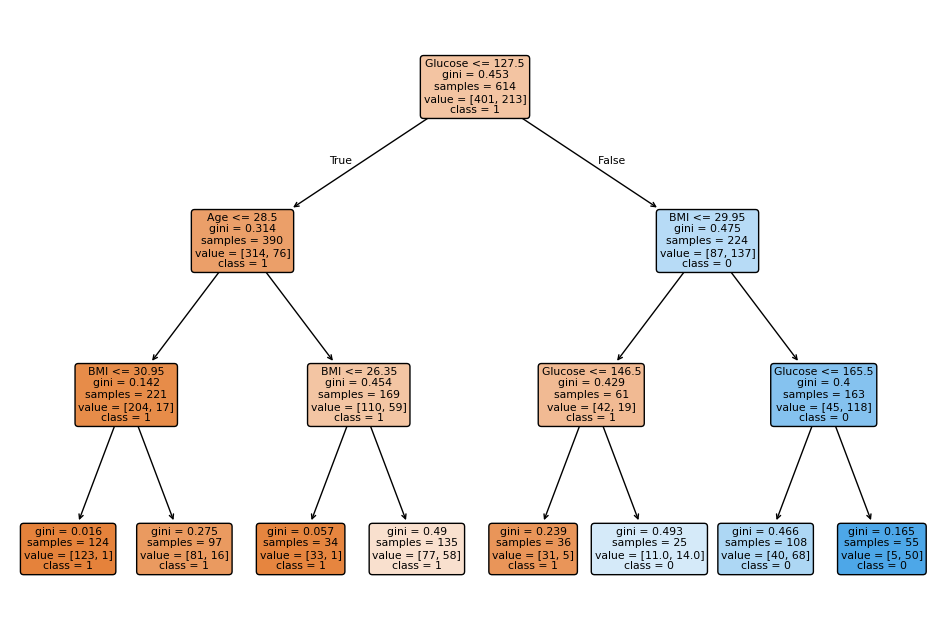

In [92]:
# display this tree
from sklearn import tree
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(12, 8))
tree.plot_tree(best_model, filled=True, feature_names=X.columns, class_names=y.unique().astype(str), rounded=True)
plt.show()

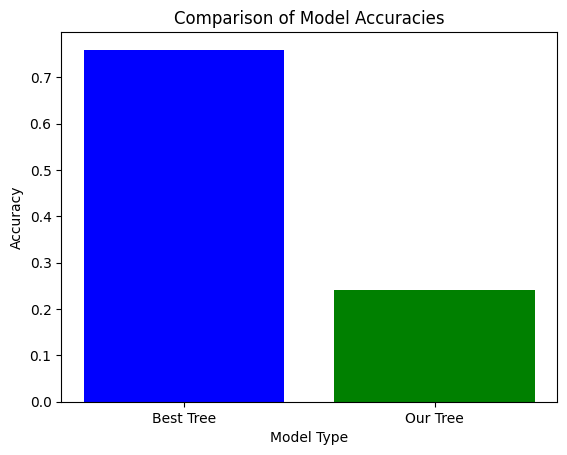

In [94]:
# compare best tree and our own tree with bar graph

import matplotlib.pyplot as plt

x = ["Best Tree", "Our Tree"]

y = [pre_buit_accuracy_test, own_acc_test]

# make bar graph

plt.bar(x, y, color=['blue', 'green'])

# Add titles and labels
plt.title("Comparison of Model Accuracies")
plt.xlabel("Model Type")
plt.ylabel("Accuracy")

# Display the graph
plt.show()